# Ch. 13: Storytelling ML

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import statsmodels.api as sm
import cycler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


# Simulations for ex-post storytelling ("opening the black box")

* Let's simulate a model with two features and some extra correlated dummy features 

$$
\begin{eqnarray}
y &=& \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon \\
x_2, z_1, z_2 &\sim& N(0, \Sigma(\rho))
\end{eqnarray}
$$

In [128]:
def compute_vcv(rho, size_z, var_z):
    """
    Given a correlation parameter between x1 and x2 (omitted) calculate the vcv to get draws
        This function really simplifies the calculation making the VCV a function only of
        the correlation.  I force the variances to be 1 to have a unique free parameter.
        Sigma = Const(rho) + I*(sigma-rho) where Const(rho) is an nxn constant matrix fixed at rho
    Inputs:
        rho: float between -1,1: correlation for z1, z2, ...
        size_z: number of variables to simulate
        var_z: constant variance for all rand. vars
    Output:
        vcv: array with variance covariance matrix
    """
    # Sigma 
    eye_n = np.identity(size_z)
    rho_n = np.full((size_z, size_z), rho)
    vcv = rho_n + eye_n*(var_z-rho)

    
    return vcv

test_vcv = compute_vcv(rho=0.5, size_z=5, var_z=3)
print(pd.DataFrame(test_vcv))


     0    1    2    3    4
0  3.0  0.5  0.5  0.5  0.5
1  0.5  3.0  0.5  0.5  0.5
2  0.5  0.5  3.0  0.5  0.5
3  0.5  0.5  0.5  3.0  0.5
4  0.5  0.5  0.5  0.5  3.0


In [129]:
def simulate_linear_model(alpha, rho, var_z, size_z, sigma_eps, nobs, seed):
    """
    Simulate a linear model with extra dummy correlated variables
    alpha: 3x1 array with equation parameters
    rho: correlation coefficient for simulating Z
    var_z: constant common variance for all zs
    size_z: size(x2, z1, z2, ...)
    sigma_eps: variance for residual
    nobs: number of observations
    seed: integer to set the seed for the random number genertor
    """
    np.random.seed(seed)
    # simulate Z and X
    cov = compute_vcv(rho, size_z, var_z)
    mean = [0]*size_Z
    cols_z = ['x2'] + [f'z{i}' for i in range(1, size_Z)]
    zdf = pd.DataFrame(np.random.multivariate_normal(mean, cov, size=nobs), 
                    columns = cols_z)
    xdf = pd.DataFrame([1]*nobs, columns = ['x0'])
    xdf['x1'] = np.random.randn(nobs)  # x1 ~ N(0,1)
    xdf['x2'] = zdf['x2']
    # simulate y
    epsilon = np.sqrt(sigma_eps)*np.random.randn(nobs)
    ydf = pd.DataFrame(np.dot(xdf, alpha) + epsilon, columns = ['y'])
    # test with first observation
    test_obs = 0
    test1 = (xdf['x0'].loc[test_obs]*alpha[0] + 
            xdf['x1'].loc[test_obs]*alpha[1] +  
            xdf['x2'].loc[test_obs]*alpha[2] + 
            epsilon[test_obs])
    assert np.abs(test1-ydf.y.loc[test_obs]) < 1e-10 
    # xdf for estimation: drop constant
    xdf_est = pd.concat((xdf[['x1','x2']], 
                         zdf[[col for col in zdf.columns if col!='x2']]), axis=1)
    return ydf, xdf_est

In [130]:
def standardize_df(df):
    df_std = (df - df.mean())/df.std()
    return df_std

# test standardization was done correctly
df_test = pd.DataFrame(np.random.randn(100,3))
std_test = standardize_df(df_test)
assert all(std_test.mean() < 1e-10)
assert all(np.abs(1-std_test.std()) < 1e-10)


In [131]:
# simulate a dataset:
# I want x2 to be more "important" than x1 in some sense
# Two tricks: var(x2) > var(x1) and abs(a2)>abs(a1)
a0,a1,a2 = 3, 1, -3
a0,a1,a2 = 3, 1, 1
alpha = [a0,a1,a2]
rho = 0.9
var_z = 5
size_Z = 4
sigma_eps = 1
nobs = 100
seed = 52113

ydf, xdf = simulate_linear_model(alpha, rho, var_z, size_Z, sigma_eps, nobs, seed)
# standarize dataset
ydf_std = standardize_df(ydf)
xdf_std = standardize_df(xdf)

In [132]:
# I'll use statsmodels to get pvalues also
xdf1 = sm.add_constant(xdf)
reg = sm.OLS(ydf['y'], xdf1).fit()
reg_std = sm.OLS(ydf['y'], xdf_std).fit()

# parameters
pars = reg.params.loc[[ix for ix in reg.params.index if ix != 'const']]
pars_std = reg_std.params
# variances
std_err = np.sqrt(np.diag(reg.cov_params()))[1:]  # drop constant
std_err_std = np.sqrt(np.diag(reg_std.cov_params()))
# pvalues
pvals = reg.pvalues.loc[[ix for ix in reg.params.index if ix != 'const']]
pvals_std = reg_std.pvalues

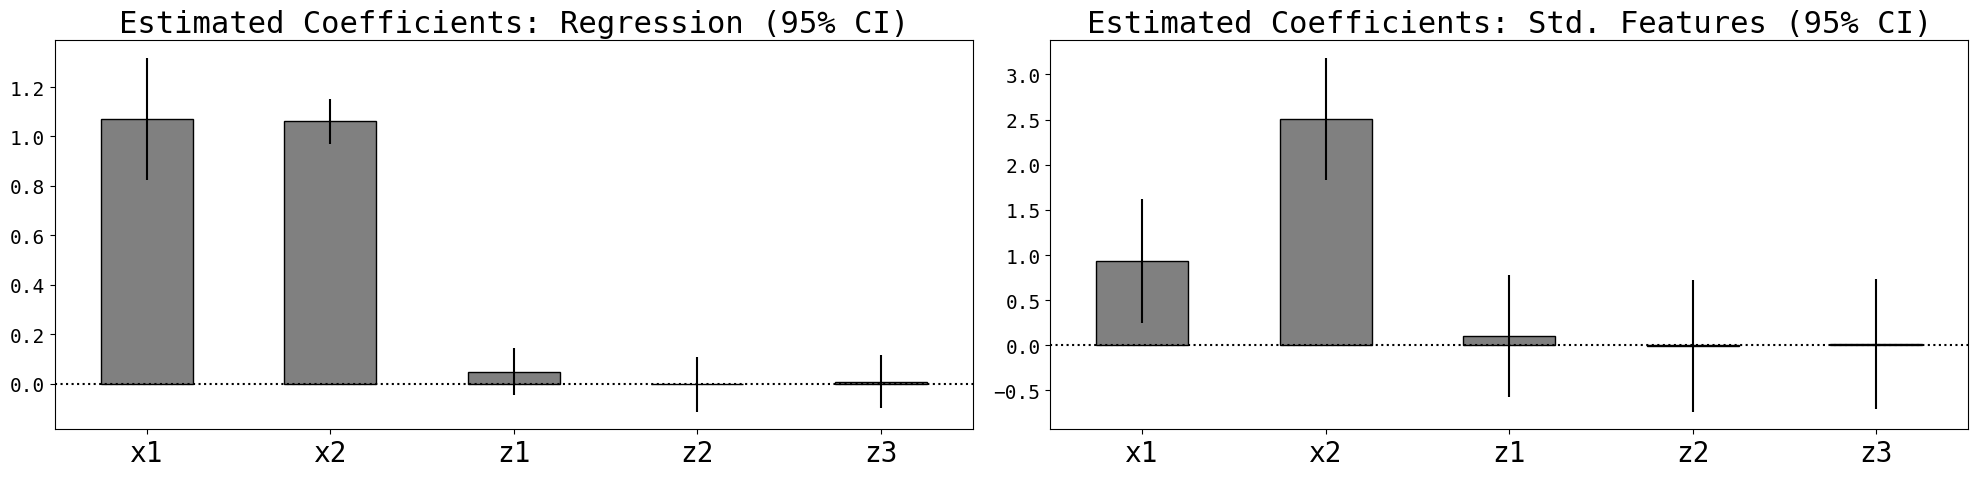

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=False)
crit_val = 1.96
pars.plot(ax=ax[0], kind='bar', yerr = crit_val*std_err, edgecolor = 'k', facecolor='0.5')
pars_std.plot(ax=ax[1], kind='bar', yerr = crit_val*std_err_std, edgecolor = 'k', facecolor='0.5')
title_dict = {0:'Estimated Coefficients: Regression (95% CI)', 1:'Estimated Coefficients: Std. Features (95% CI)'}
for i in range(2):
    labsi = ax[i].get_xticklabels()
    labsi = ax[i].set_xticklabels(labsi, rotation = 0, fontsize = 20)
    ax[i].set_title(title_dict[i])
    xmin, xmax = ax[i].get_xlim()
    ax[i].plot([xmin, xmax], [0,0], ls = 'dotted')

# Heatmaps for regression and classification

In [134]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap using LinearSegmentedColormap
    See the discussion in 
    https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [135]:
def plot_feature_heatmap(df, df_norm, ax, cmap, max_feats=20):
    """
    Given a df plot a heatmap of max_feats rows
        Since features are measured in different units, I use a standardized version to color
    Inputs:
        df: DF for heatmap
        df_norm: DF with normalized values
        ax: axis object
        max_feats: maximum number of features to include (useful to focus on top only)
    """
    df_norm = df_norm.loc[df_norm.index[:max_feats]]
    df = df.loc[df.index[:max_feats]]
    hm_plt = df.iloc[:max_feats,:]
    im = ax.imshow(df_norm, cmap = cmap)
    # Show all ticks and label them with the respective list entries
    y_len, x_len = df_norm.shape
    ax.set_xticks(np.arange(x_len))
    ax.set_yticks(np.arange(y_len))
    ax.set_xticklabels(df_norm.columns, rotation = 0)
    ax.set_yticklabels(df_norm.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(y_len):
        for j in range(x_len):
            text = ax.text(j, i, np.around(hm_plt.values[i, j], decimals = 2), 
                                ha="center", va="center", color="k", fontsize = 12,
                                weight='bold')
    ax.set_ylabel('Features (sorted by importance)')
    ax.set_xlabel('Deciles')
    
    return ax

In [136]:
def create_feature_heatmap(model, ydf, xdf, ax, importance_order = 'permutation', is_regression = True, 
                  cmap = cm.Blues, max_feats = 20):
    """
        Create a heatmap to visualize correlations between predicted
        outcomes and features
    Inputs:
        model: model object that can be used to create predictions
        xdf: dataframe with features (better if you use the test sample)
        ydf: dataframe with outcome (necessary to compute TPR or MSE)
        ax: axis object to make the heatmap
        importance_order: sort by importance
            "impurity": use impurity-based feature importance (if available)
            "permutation": use permutation-based importance (always works --> default)
        is_regression: Boolean: True if model is linear regression, False if classification
        max_feats: maximum number of features to plot (default is 20: so plot top 20 given importance)
    Outputs:
        axis object with heatmap

    """
    xdf_std = standardize_df(xdf)  # used for plotting only (see plot_heatmap())
    labs_dec = [f'd{i}' for i in range(1,11)]
    if is_regression:
        yhat = pd.DataFrame(model.predict(xdf), columns = ['yhat'])
        title_str = 'Yhat deciles'
    else:
        yhat = pd.DataFrame(model.predict_proba(xdf)[:,1], columns = ['yhat'])
        title_str = 'Score deciles'
    # compute deciles and average features by decile
    deciles = pd.qcut(x=yhat.yhat.values, q=10, labels=labs_dec, duplicates='drop')
    avg_df = xdf.groupby(deciles).mean().T
    avg_df_std = xdf_std.groupby(deciles).mean().T
    # NEW: get TPR by bucket
    tpr_df = pd.DataFrame(ydf.groupby(deciles).mean())
    if is_regression==False:
        list_tpr_labels = [f'{k} \n ({round(100*v,1)}%)' for   k,v in tpr_df.squeeze().to_dict().items()]
    else:
        list_tpr_labels = [f'{k} \n ({round(v,1)})' for   k,v in tpr_df.squeeze().to_dict().items()]
    # sort features and save in a DF, sorted
    if importance_order == 'impurity':
        try:
            feat_imp = model.feature_importances
        except AttributeError:
            print('WARNING! \nimpurity importance not available \nUsing order in xdf')
            feat_imp = range(len(xdf.columns))[::-1]
    elif importance_order == 'permutation':
        dict_impo = permutation_importance(model, xdf, ydf, n_repeats=10,random_state=2506)
        feat_imp = dict_impo['importances_mean']
    feat_df = pd.DataFrame(feat_imp, index = xdf.columns, columns = ['feature_imp'])
    feat_df = feat_df.sort_values(by = 'feature_imp', ascending = False)
    # sort using importances
    avg_df = avg_df.loc[feat_df.index]
    avg_df_std = avg_df_std.loc[feat_df.index]
    # ready to plot
    cmap = plt.get_cmap(cmap)
    new_cmap = truncate_colormap(cmap=cmap, minval=0.0, maxval=0.8, n=10)
    ax = plot_feature_heatmap(df=avg_df, df_norm=avg_df_std, ax=ax, cmap=new_cmap, max_feats=max_feats)
    ax.set_xlabel(title_str)
    ax.set_xticklabels(list_tpr_labels, fontsize=12)
    return ax

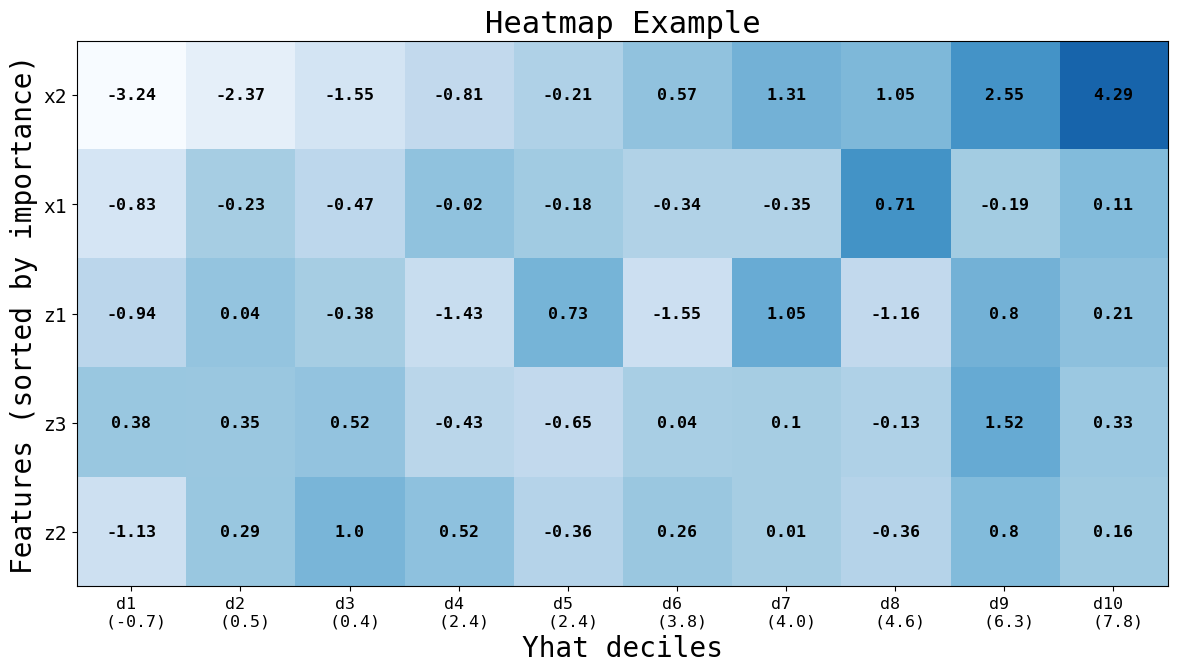

In [137]:
reg = LinearRegression().fit(xdf, ydf.y)
fig, ax = plt.subplots(figsize=(12,8))
ax = create_feature_heatmap(model=reg, ydf=ydf, xdf=xdf, ax=ax, 
                            importance_order = 'permutation', is_regression = True)
ttl = ax.set_title('Heatmap Example')

Text(0.5, 1.0, 'Scatterplot of $x_2$ and $x_1$')

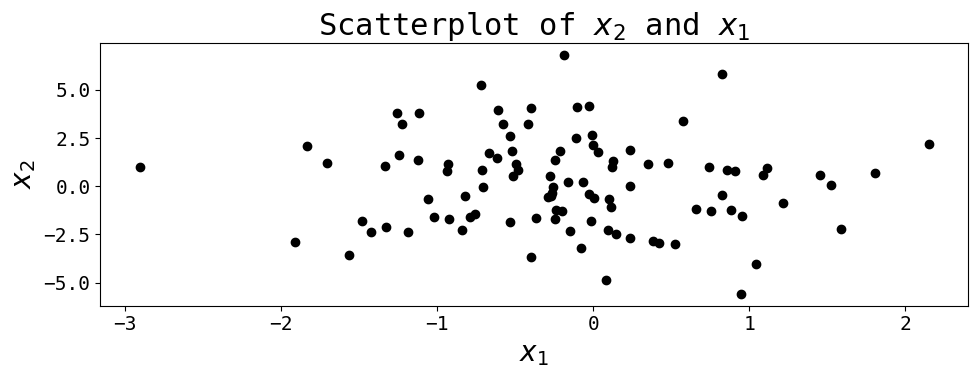

In [138]:
fig, ax = plt.subplots()
ax.scatter(x=xdf.x1, y=xdf.x2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title(r'Scatterplot of $x_2$ and $x_1$')

## Feature Importance

* With the same simulated dataset let's train a gradient boosting regression and compute `impurity` and `permutation` feature importances
* As usual, I won't optimize metaparameters (but you should)

In [139]:
state = 2506
X_train, X_test, y_train, y_test = train_test_split(xdf, ydf.y, random_state=state)
reg = GradientBoostingRegressor(random_state=state).fit(X_train, y_train)
# permutation importances
dict_perm = permutation_importance(reg, xdf, ydf, n_repeats=10,random_state=state)
perm_mean = pd.DataFrame(dict_perm['importances_mean'], index = xdf.columns, columns = ['mean_perm'])
perm_mean['std_perm'] = dict_perm['importances_std']
perm_mean.sort_values(by = 'mean_perm', ascending = True, inplace=True)
# impurity importance
impu_mean = pd.DataFrame(reg.feature_importances_, index = xdf.columns, columns = ['mean_impurity'])
# everything in one
perm_mean = perm_mean.merge(impu_mean, left_index=True, right_index=True)
perm_mean

,mean_perm,std_perm,mean_impurity
z3,0.009256,0.002466,0.017615
z2,0.014900,0.002492,0.024592
z1,0.015266,0.003879,0.017520
x1,0.156640,0.024468,0.094686
x2,1.621922,0.188077,0.845587


In [140]:
# let's compute CI for impurity based using bootstrapping
# Note that there are multiple ways to randomize here:
# 
B = 300
n_b = X_train.shape[0]
df_impurity = pd.DataFrame(index = range(B), columns = xdf.columns)
for b in range(B):
    # Randomly select rows from train with replacement
    ix_b = np.random.choice(X_train.index, size=n_b, replace=True)
    X_train_b, y_train_b = X_train.loc[ix_b], y_train.loc[ix_b]
    reg_b = GradientBoostingRegressor(random_state=state).fit(X_train_b, y_train_b)
    impu_b = reg_b.feature_importances_
    df_impurity.loc[b] = impu_b

boot_std_imp = df_impurity.std().loc[perm_mean.index]
boot_mean_imp = df_impurity.mean().loc[perm_mean.index]
print(boot_mean_imp)

z3     0.01853
z2    0.027144
z1    0.021329
x1    0.090324
x2    0.842673
dtype: object


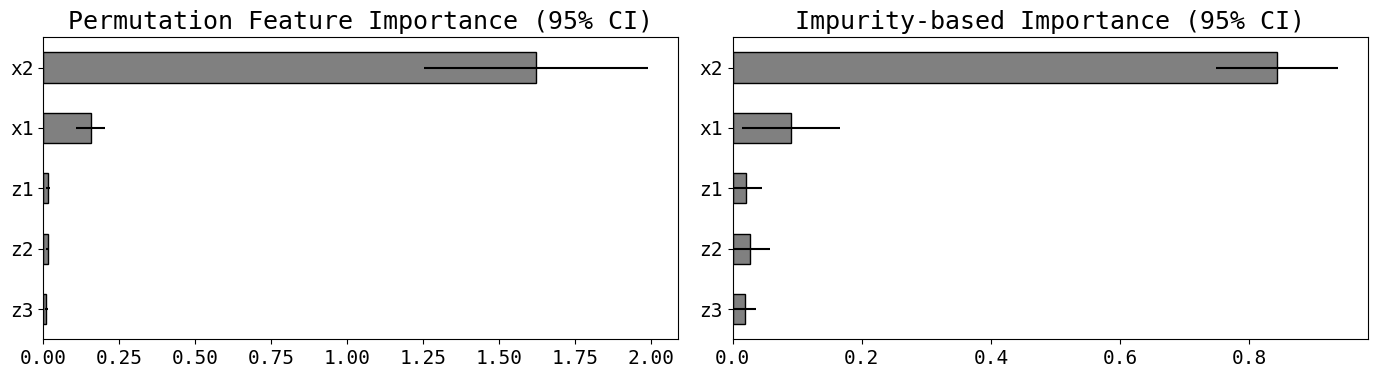

In [141]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
n_feats = len(xdf.columns)
perm_mean.mean_perm.plot(ax = ax[0], kind='barh', facecolor = '0.5', edgecolor='k', xerr=1.96*perm_mean.std_perm)
boot_mean_imp.plot(ax = ax[1], kind='barh', facecolor = '0.5', edgecolor='k', xerr = 1.96*boot_std_imp)
ax[0].set_title('Permutation Feature Importance (95% CI)', fontsize = 18)
ax[1].set_title('Impurity-based Importance (95% CI)', fontsize = 18)
# fix ax[1]
xmin, xmax = ax[1].get_xlim()
xlim = ax[1].set_xlim([0, xmax])


## Partial Dependence Plots

There are two ways to calculate these:

1. Method used in Ch.9 
$$
\text{PDP}(x_1) = f(X[grid(x1),\overline{x}_2, \cdots, \overline{x}_k])
$$

2. Better method:
$$
\text{PDP}(x_1=k) = \frac{1}{N}\sum_{i=1}^N f(k, x_{2,i}, \cdots, x_{k,i})
$$


**Note the difference**:
(2) computes the prediction for each unit in your sample at each point in the grid for the feature, and then averages the result.  This is the mathematically sound way to do it, because a function evaluated on the average (method 1) is not the average of the function (unless the function is linear).

Let's do some simulations to ensure that this is the case.

In [142]:
def compute_pdp1(xdf, var_name, model, drop_outliers = True, pmin = 0.05, pmax = 0.95, is_regression=True):
    """
    Version 1 of PDPs: calculate mean matrix and make only one prediction
        Compare to Version 2 below.
    Inputs:
        xdf: DF with features (better if this comes from test sample)
        var_name: feature in xdf to compute the PDP
        model: model object (needs to have `predict` or `predict_proba` methods)
        drop_outliers: Boolean: True if you want to drop outliers (recommended)
        pmin, pmax: percentiles that define lower and upper thresholds for outliers
        is_regression: Boolean: True if regression, False if classification
    """
    # calculate grid
    ncols = len(xdf.columns)
    if drop_outliers:
        xmin, xmax = xdf[var_name].quantile([pmin, pmax])
    else:
        xmin, xmax = xdf[var_name].min(), xdf[var_name].max()
    grid_size = 20
    grid = np.linspace(xmin, xmax, grid_size)
    # calculate means
    df_means = xdf.mean().repeat(repeats=grid_size).values.reshape(ncols, grid_size).T
    df_means = pd.DataFrame(df_means, index=grid, columns = xdf.columns)
    # insert grid in means
    df_means[var_name] = grid
    # predict
    if is_regression:
        pdp = model.predict(df_means)
    else:
        pdp = model.predict_proba(df_means)
    
    pdp = pd.DataFrame(pdp, index=grid, columns=[f'pdp_{var_name}'])
    return pdp

test_pdp1 = compute_pdp1(xdf=xdf, var_name='z3', model=reg, is_regression=True)    
test_pdp1.head()

,pdp_z3
-2.680884,3.096326
-2.341984,3.096326
-2.003083,3.096326
-1.664182,2.881066
-1.325282,2.860187


In [143]:
def predict_wrapper(model, is_regression):
    "Wrapper to select the right predict function"
    if is_regression:
        my_func = model.predict
    else:
        my_func = model.predict_proba

    return my_func

In [144]:
def compute_pdp2(xdf, var_name, model, drop_outliers = True, pmin = 0.05, pmax = 0.95, is_regression=True):
    """
    Second version of PDPs: make individual predictions and average them out.  
    Note that I can save all individual predictions to compute ICE
    Inputs:
        xdf: DF with features (better if this comes from test sample)
        var_name: feature in xdf to compute the PDP
        model: model object (needs to have `predict` or `predict_proba` methods)
        drop_outliers: Boolean: True if you want to drop outliers (recommended)
        pmin, pmax: percentiles that define lower and upper thresholds for outliers
        is_regression: Boolean: True if regression, False if classification
    """
    # calculate grid
    ncols = len(xdf.columns)
    if drop_outliers:
        xmin, xmax = xdf[var_name].quantile([pmin, pmax])
    else:
        xmin, xmax = xdf[var_name].min(), xdf[var_name].max()
    grid_size = 20
    grid = np.linspace(xmin, xmax, grid_size)
    # loop over grid and predict
    col_lab = f'pdp_{var_name}'
    pdp = pd.DataFrame(index=grid, columns = [col_lab])
    ice_df = pd.DataFrame(index=xdf.index, columns = grid)
    for g, grd in enumerate(grid):
        xdfg = xdf.copy()
        xdfg[var_name] = grd
        if is_regression:
          yhat = model.predict(xdfg)
        else:
          yhat = model.predict_proba(xdfg)[:,1]

        ice_df[grd] = yhat
        pdp_g = np.mean(yhat) # average of the predictions
        pdp[col_lab].loc[grd] = pdp_g
    return pdp, ice_df
test_pdp2, ice_test = compute_pdp2(xdf=xdf, var_name='z3', model=reg, is_regression=True)    
test_pdp2.head()    

,pdp_z3
-2.680884,3.335506
-2.341984,3.335506
-2.003083,3.334643
-1.664182,3.153614
-1.325282,3.148063


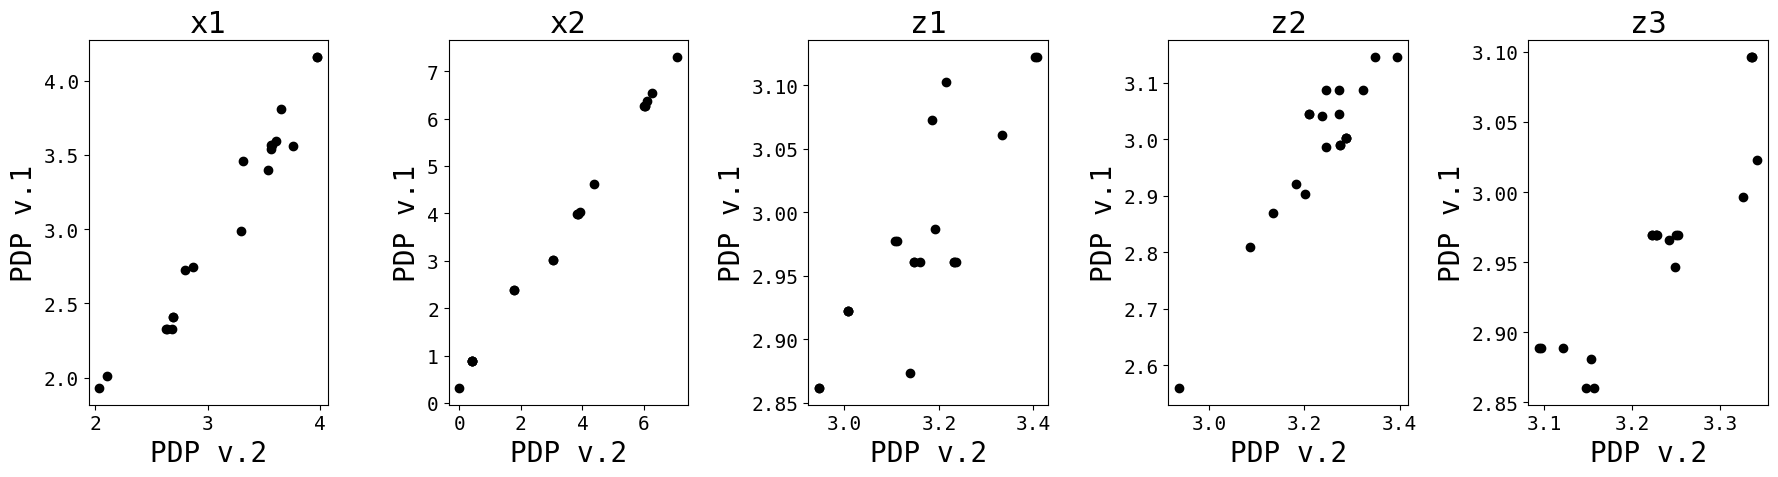

In [145]:
# let's compare both versions of PDPs using the GBR model
fig, ax = plt.subplots(1,5, figsize=(18,5))
for i in range(5):
    col_i = xdf.columns[i]
    xi,_ = compute_pdp2(xdf=xdf, var_name=col_i, model=reg)
    xi = xi.values
    yi = compute_pdp1(xdf=xdf, var_name=col_i, model=reg).values
    ax[i].scatter(xi, yi)
    ax[i].set_xlabel('PDP v.2')
    ax[i].set_ylabel('PDP v.1')    
    ax[i].set_title(col_i)

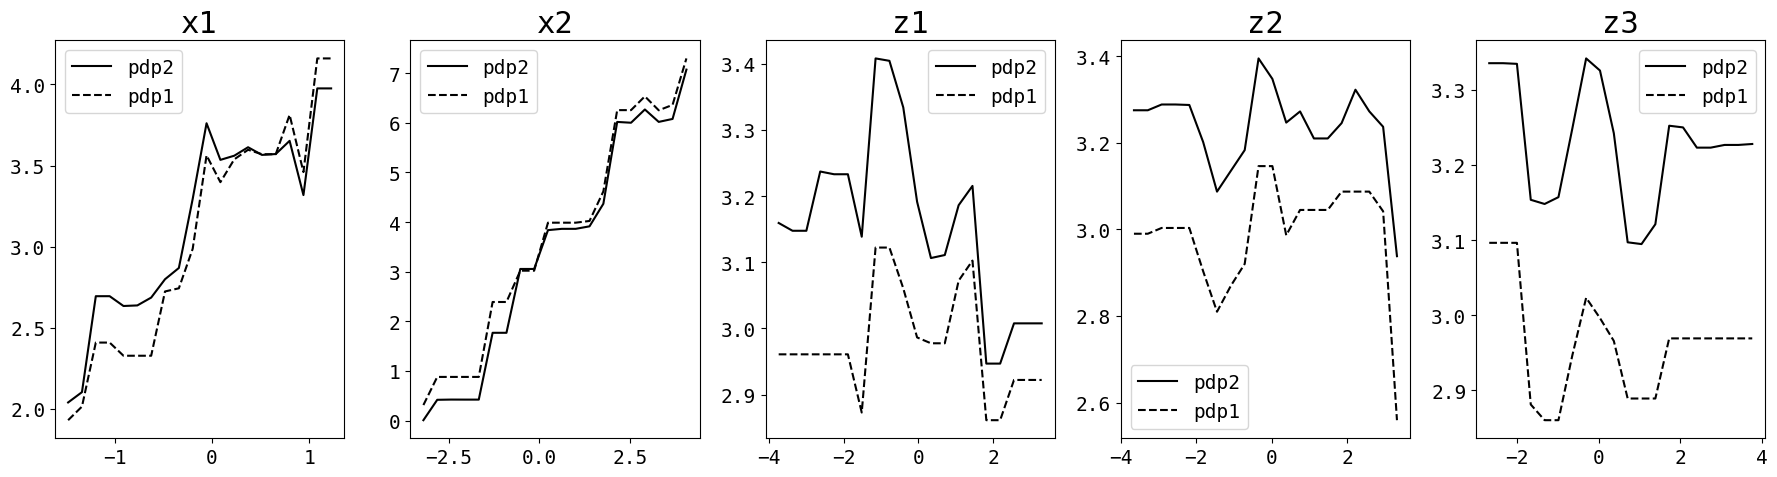

In [146]:
#Let's see what's going on with x1
# let's compare both versions of PDPs using the GBR model
fig, ax = plt.subplots(1,5, figsize=(18,5))
for i in range(5):
    col_i = xdf.columns[i]
    p2,_ = compute_pdp2(xdf=xdf, var_name=col_i, model=reg)
    p1 = compute_pdp1(xdf=xdf, var_name=col_i, model=reg)
    p2.plot(ax=ax[i], color = 'k')
    p1.plot(ax=ax[i], color = 'k', ls='--')
    ax[i].legend(['pdp2', 'pdp1'])
    ax[i].set_title(col_i)

### In passing, let's plot the _Individual Conditional Expectation_ (ICE) plots
* These are directly computed with the second version of PDPs

<Axes: title={'center': 'ICE plots for the sample ($x_1$)'}, xlabel='Linear grid for $x_1$', ylabel='Predicted Outcome'>

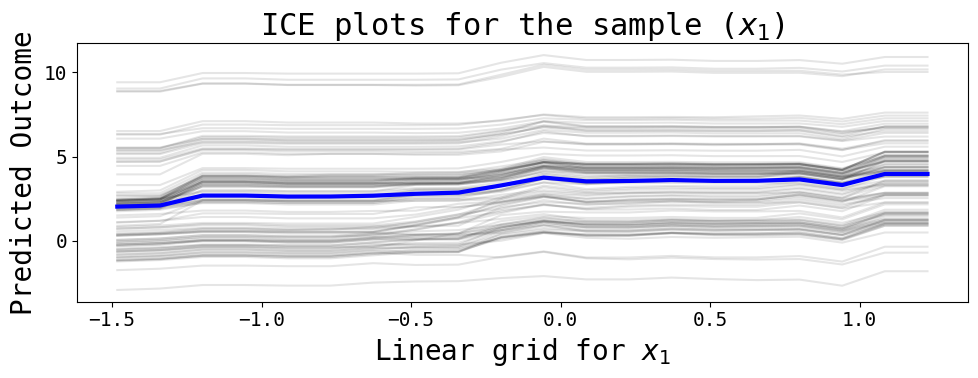

In [147]:
_, ice_x1 = compute_pdp2(xdf=xdf, var_name='x1', model=reg)
fig, ax = plt.subplots()
mean_ice = ice_x1.mean()
ice_x1 = ice_x1.T  # transpose for easy plotting
ice_x1.plot(alpha=0.1, ax = ax)
ax.get_legend().remove()
ttl = ax.set_title(r'ICE plots for the sample ($x_1$)')
xlab = ax.set_xlabel(r'Linear grid for $x_1$')
ylab = ax.set_ylabel('Predicted Outcome')
mean_ice.plot(ax=ax, color='b', lw=3)


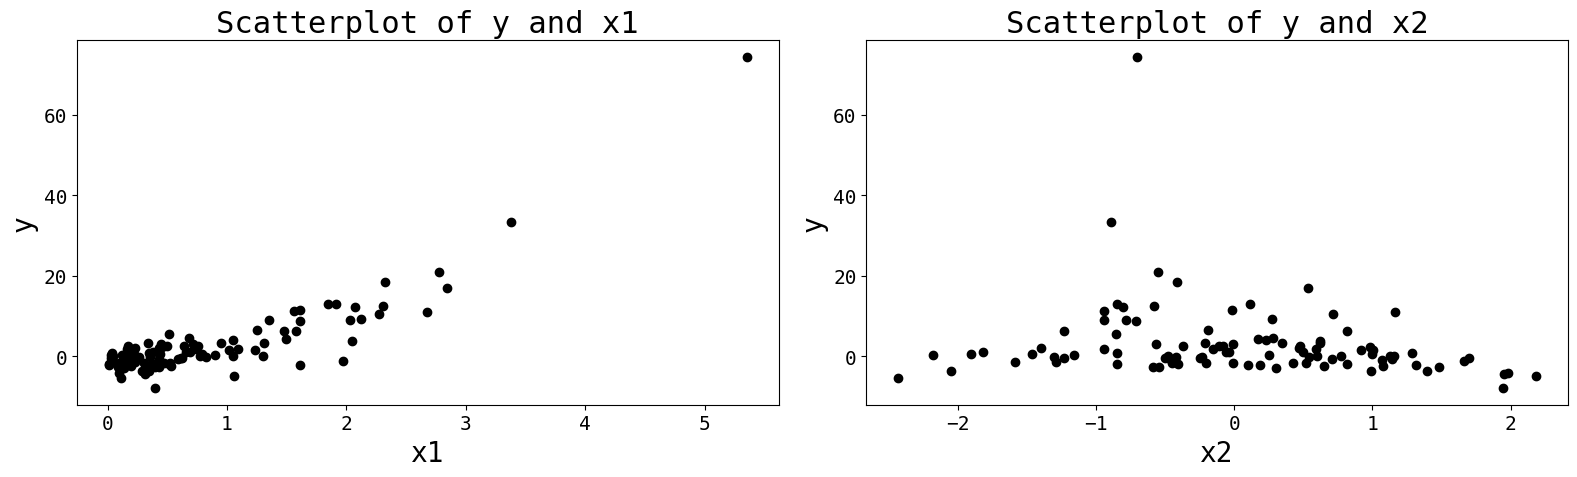

In [148]:
#let's simulate a nonlinear model: y = a0*x1 + a1*x1^2 + a2*x1*x2 + a3*x2^2
a0,a1,a2,a3 = 1,2,-2,-1
np.random.seed(41414)
nobs = 100
var_x2 = 1
var_eps = 5
x1 = np.random.gamma(shape=1, scale=1, size=nobs)
x2 = np.sqrt(var_x2)*np.random.randn(nobs)
epsilon = np.sqrt(var_eps)*np.random.randn(nobs)
y = a0*x1 + a1*x1**2 + a2*x1*x2 + a3*x2**2 + epsilon

ydf = pd.DataFrame(y, columns = ['y'])
xdf = pd.DataFrame(x1, columns = ['x1'])
xdf['x2'] = x2

# train GBR
gbr_nl = GradientBoostingRegressor(random_state=state).fit(xdf, ydf.y)

# plot for descriptive purposes
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax[0].scatter(x1, y)
ax[1].scatter(x2, y)
ax[0].set_xlabel('x1')
ax[1].set_xlabel('x2')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')
tlt = ax[0].set_title('Scatterplot of y and x1')
tlt = ax[1].set_title('Scatterplot of y and x2')

Text(0.5, 1.0, 'True PDP X2')

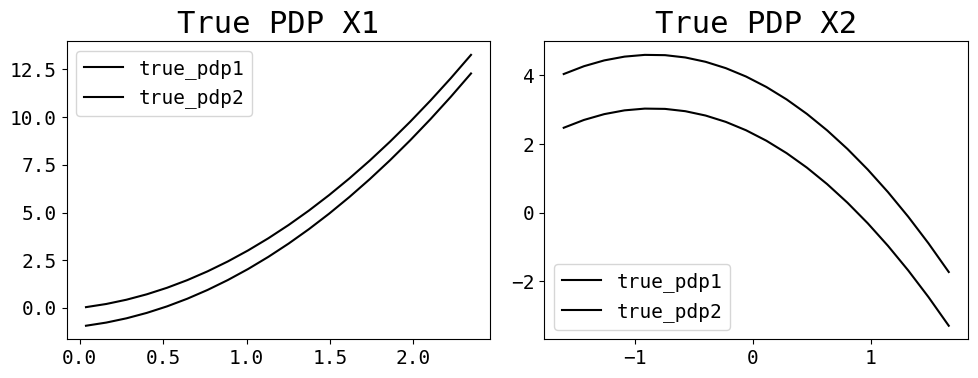

In [149]:
def simulate_true_pdps(alpha, xdf, var_name, drop_outliers=True, pmin=0.05, pmax=0.95):
    "Simulate true PDP for var_name"
    # Version 1:
    ncols = len(xdf.columns)
    if drop_outliers:
        xmin, xmax = xdf[var_name].quantile([pmin, pmax])
    else:
        xmin, xmax = xdf[var_name].min(), xdf[var_name].max()
    grid_size = 20
    grid = np.linspace(xmin, xmax, grid_size)
    df_means = xdf.mean().repeat(repeats=grid_size).values.reshape(ncols, grid_size).T
    df_means = pd.DataFrame(df_means, index=grid, columns = xdf.columns)
    df_means[var_name] = grid
    x1 = df_means['x1']
    x2 = df_means['x2']
    true_pdp1 = alpha[0]*x1 + alpha[1]*x1**2 + alpha[2]*x1*x2 + alpha[3]*x2**2
    df_true = pd.DataFrame(true_pdp1, columns = ['true_pdp1'])
    # Version 2:
    true_pdp2 = pd.DataFrame(index=grid, columns = ['true_pdp2'])
    xdf_sim = xdf.copy()
    for grd in grid:
        xdf_sim[var_name] = grd
        x1 = xdf_sim['x1'].values
        x2 = xdf_sim['x2'].values
        ysim = alpha[0]*x1 + alpha[1]*x1**2 + alpha[2]*x1*x2 + alpha[3]*x2**2
        mean_sim = np.mean(ysim)
        true_pdp2['true_pdp2'].loc[grd] = mean_sim
        
    df_true = df_true.merge(true_pdp2, left_index=True, right_index=True)
    return df_true

alpha = [a0,a1,a2,a3]
df_true_x1 = simulate_true_pdps(alpha, xdf, var_name='x1')
df_true_x2 = simulate_true_pdps(alpha, xdf, var_name='x2')
fig, ax = plt.subplots(1,2)
df_true_x1.plot(ax=ax[0])
df_true_x2.plot(ax=ax[1])
ax[0].set_title('True PDP X1')
ax[1].set_title('True PDP X2')

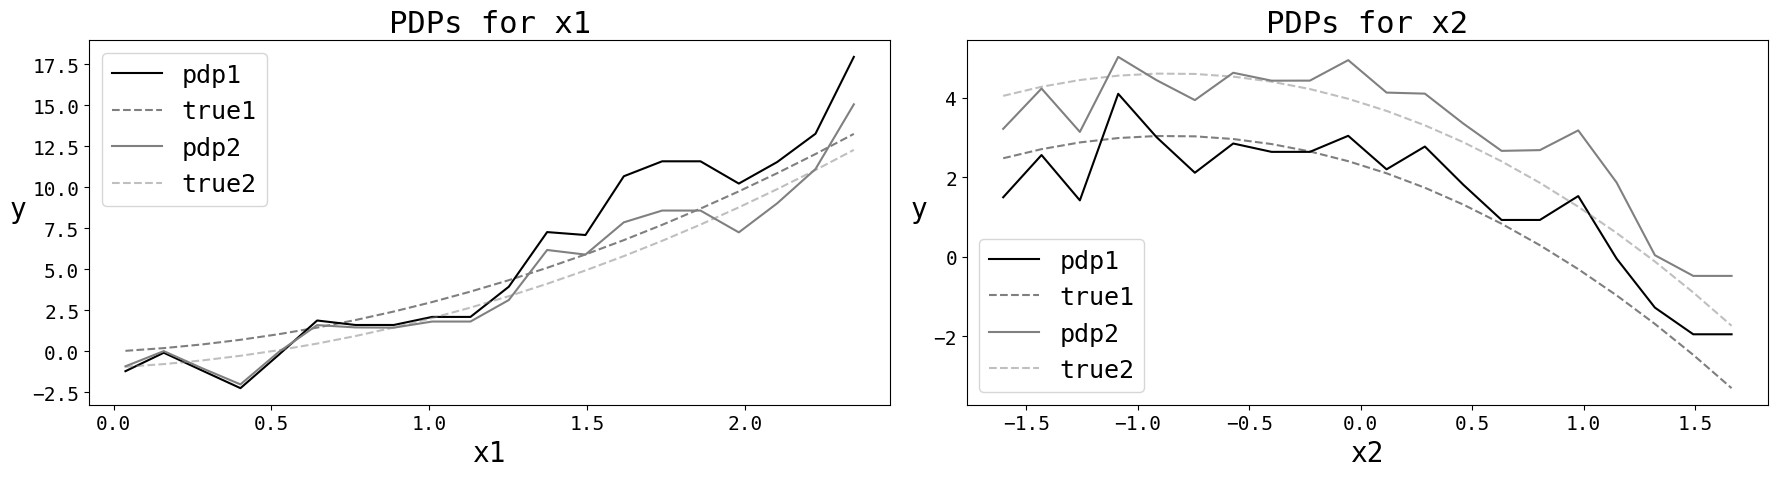

In [150]:
#Let's see what's going on with x1
# let's compare both versions of PDPs using the GBR model
fig, ax = plt.subplots(1,2, figsize=(18,5))
for c, col in enumerate(xdf.columns):
    p2,_ = compute_pdp2(xdf=xdf, var_name=col, model=gbr_nl)
    p1 = compute_pdp1(xdf=xdf, var_name=col, model=gbr_nl)
    true_pdp = simulate_true_pdps(alpha, xdf, var_name=col)
    # plot
    p1.plot(ax=ax[c], color = 'k', ls='-')
    true_pdp['true_pdp1'].plot(ax=ax[c], color='k', ls='--', alpha=0.5)
    p2.plot(ax=ax[c], color = '0.5')
    true_pdp['true_pdp2'].plot(ax=ax[c], color='0.5', ls='--', alpha=0.5)
    ax[c].legend(['pdp1', 'true1', 'pdp2', 'true2'], fontsize=18)
    ax[c].set_title(f'PDPs for {col}')
    ax[c].set_ylabel('y ', rotation=0)
    ax[c].set_xlabel(col, rotation=0)    

In [151]:
# let's run some bootstrapping to compute CI
def bootstrap_pdp(xdf, model, var_name, b_samples = 300, pdp_func = compute_pdp2):
    pdp_boot_df = pd.DataFrame(index=range(b_samples), columns = range(20), dtype='float')
    for b in range(b_samples):
        ix_b = np.random.choice(xdf.index, nobs, replace=True)
        xdf_b = xdf.loc[ix_b]
        if pdp_func == compute_pdp2:
            pdp_b,_ = pdp_func(xdf=xdf_b, var_name=var_name, model=model)
        else:
            pdp_b = pdp_func(xdf=xdf_b, var_name=var_name, model=model)
        pdp_boot_df.loc[b] = pdp_b.values.flatten()
    # compute quantiles and mean
    pdp_qtile = pdp_boot_df.quantile([0.05, 0.95])
    pdp_qtile.rename(columns={i:ix for i,ix in enumerate(pdp_b.index)}, inplace=True)
    pdp_mean = pd.DataFrame(pdp_boot_df.mean().values, index=pdp_b.index, columns = ['mean'])
    # only one dataframe
    pdp_agg = pdp_qtile.T
    pdp_agg['mean'] = pdp_boot_df.mean().values
    return pdp_agg

In [152]:
# bootstrap PDPs with v.1
pdp1_x1 = bootstrap_pdp(xdf, model=gbr_nl, var_name='x1', b_samples = 300, pdp_func = compute_pdp1)
pdp1_x2 = bootstrap_pdp(xdf, model=gbr_nl, var_name='x2', b_samples = 300, pdp_func = compute_pdp1)

# bootstrap PDPs with v.2
pdp2_x1 = bootstrap_pdp(xdf, model=gbr_nl, var_name='x1', b_samples = 300, pdp_func = compute_pdp2)
pdp2_x2 = bootstrap_pdp(xdf, model=gbr_nl, var_name='x2', b_samples = 300, pdp_func = compute_pdp2)

Text(0, 0.5, 'PDP v.2')

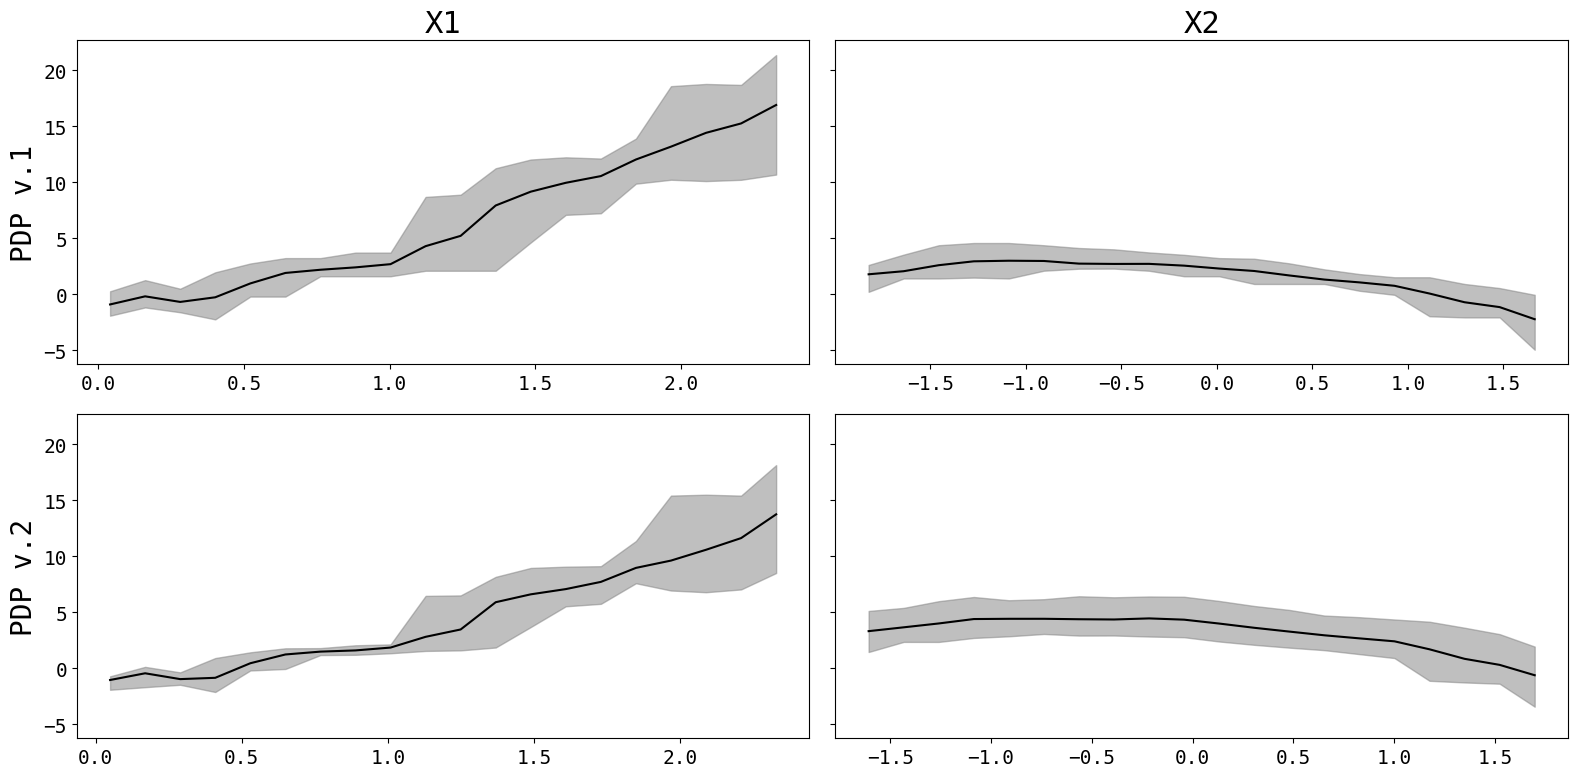

In [153]:
fig, ax = plt.subplots(2,2, figsize = (16,8), sharex=False, sharey=True)
# pdp v.1
pdp1_x1['mean'].plot(color = 'k', ax = ax[0,0])
ax[0,0].fill_between(pdp1_x1.index, pdp1_x1[0.95], pdp1_x1[0.05], color = '0.5', alpha=0.5)
pdp1_x2['mean'].plot(color = 'k', ax = ax[0,1])
ax[0,1].fill_between(pdp1_x2.index, pdp1_x2[0.95], pdp1_x2[0.05], color = '0.5', alpha=0.5)
# pdp v.2
pdp2_x1['mean'].plot(color = 'k', ax = ax[1,0])
ax[1,0].fill_between(pdp2_x1.index, pdp2_x1[0.95], pdp2_x1[0.05], color = '0.5', alpha=0.5)
pdp2_x2['mean'].plot(color = 'k', ax = ax[1,1])
ax[1,1].fill_between(pdp2_x2.index, pdp2_x2[0.95], pdp2_x2[0.05], color = '0.5', alpha=0.5)
# titles and labels
ax[0,0].set_title('X1')
ax[0,1].set_title('X2')
ax[0,0].set_ylabel('PDP v.1')
ax[1,0].set_ylabel('PDP v.2')


## PDPs with correlated features:
* Repeat simulation of nonlinear model but now have highly correlated features

In [154]:
def simulate_nl_model(alpha, rho, var_epsilon, nobs, seed):
    "Same as before but now allow for correlated normal features"
    np.random.seed(seed)
    a0,a1,a2,a3 = alpha
    cov = compute_vcv(rho, 2, 1)
    mean = [0]*2
    xdf = pd.DataFrame(np.random.multivariate_normal(mean, cov, size=nobs), 
                        columns = ['x1','x2'])
    x1 = xdf['x1']
    x2 = xdf['x2']
    var_eps = 5
    epsilon = np.sqrt(var_eps)*np.random.randn(nobs)
    y = a0*x1 + a1*x1**2 + a2*x1*x2 + a3*x2**2 + epsilon

    ydf = pd.DataFrame(y, columns = ['y'])

    
    return ydf, xdf

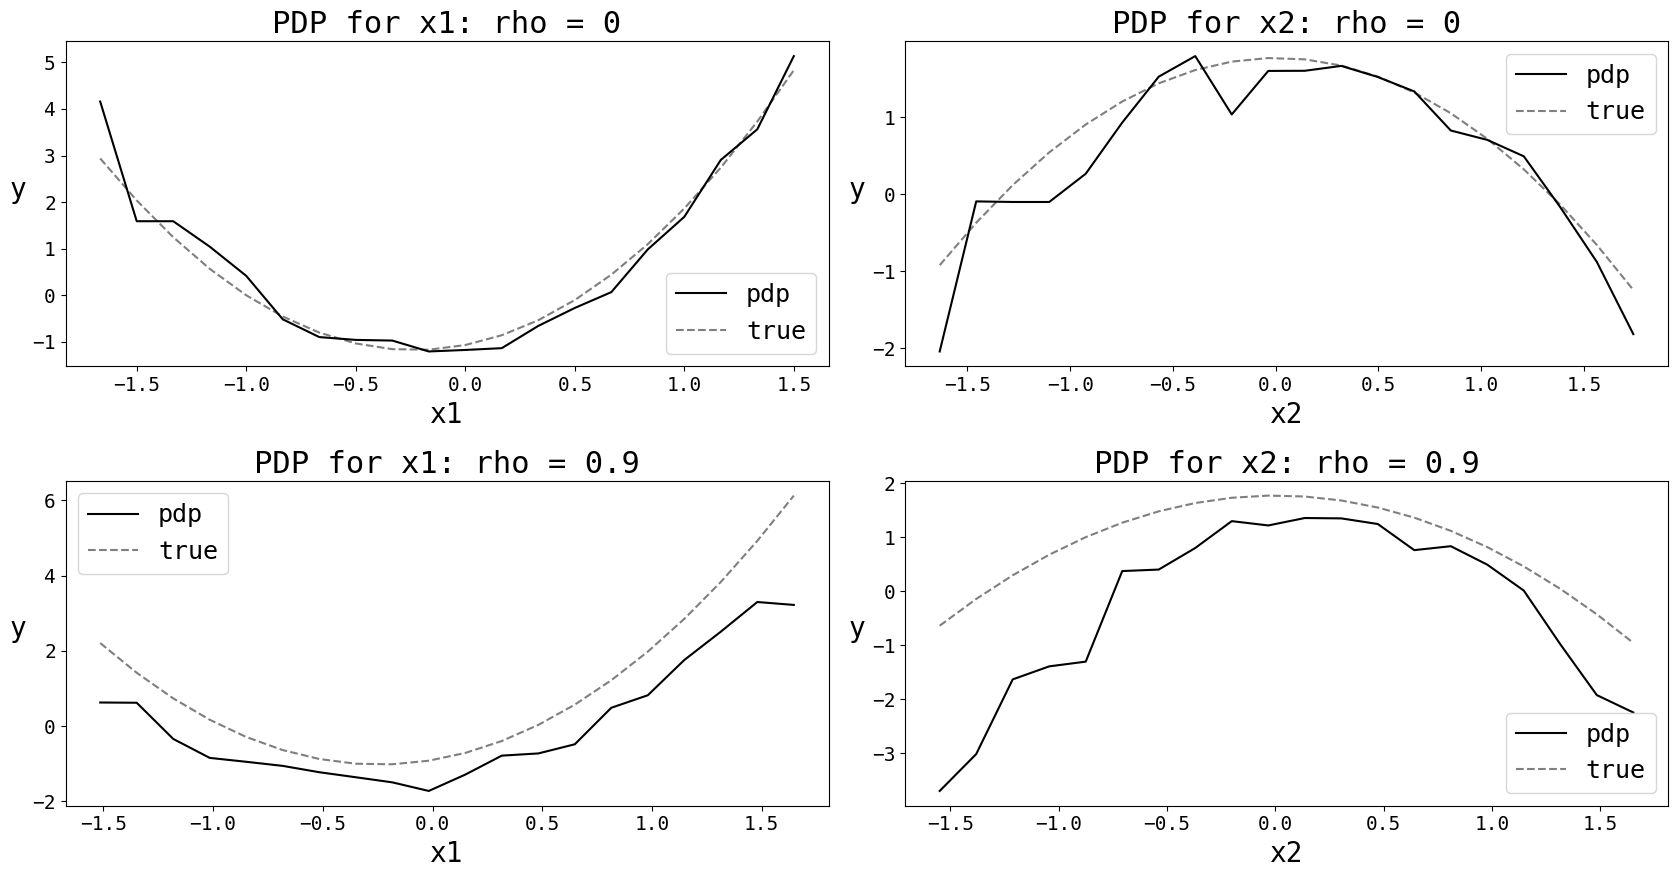

In [155]:
# simulate with and without correlation
rho_arr = [0,0.9]
fig, ax = plt.subplots(2,2, figsize = (17,9))
nobs=1000
for r,rho in enumerate(rho_arr):
    y_c, x_c = simulate_nl_model(alpha, rho=rho, var_epsilon=5, nobs=nobs, seed=67219)
    # train GBR
    gbr_nl_c = GradientBoostingRegressor(random_state=state).fit(x_c, y_c.y)
    # get PDPs
    for c, col in enumerate(x_c.columns):
        ax_rc = ax[r,c]
        p2,_ = compute_pdp2(xdf=x_c, var_name=col, model=gbr_nl_c)
        true_pdp = simulate_true_pdps(alpha, x_c, var_name=col)
        # plot
        p2.plot(ax=ax_rc, color = 'k')
        true_pdp['true_pdp2'].plot(ax=ax_rc, color='k', ls='--', alpha=0.5)
        ax_rc.legend(['pdp', 'true'], fontsize=18)
        ax_rc.set_title(f'PDP for {col}: rho = {rho}')
        ax_rc.set_ylabel('y ', rotation=0)
        ax_rc.set_xlabel(col, rotation=0)    


In [166]:
# let's try to fix this by using only units in a neighborhood of each grid point
def compute_ale(xdf, var_name, model, grid_size=20, is_regression=True):
    """
    Calculate Accumulated Local Effects (ALE):
       See: https://arxiv.org/pdf/1612.08468.pdf
    Inputs:
        Same as PDP
    Outpus:
        DF with several columns, including the ALE for var_name
    """
    predict_func = predict_wrapper(model, is_regression)
    # calculate grid
    nobs, ncols = xdf.shape
    grid = np.quantile(xdf[var_name], np.linspace(0,1,grid_size))
    # loop over grid and predict
    col_lab = f'ale_{var_name}'
    ale_df = pd.DataFrame(index=grid, columns = ['mean_delta','uncent_ale', 'mid_point', 'nobs','summand'])
    cumsum = 0
    for g, grd in enumerate(grid[:-1]):
        xdfg = xdf.copy()
        # step 1: create a neighborhood: this will be done using the grid
        top_t = grid[g+1]  # upper boundary
        bot_t = grid[g] #lower boundary
        mid_point = (bot_t + top_t)*0.5 # for reference
        loc_neigh = np.logical_and(xdf[var_name]>bot_t, xdf[var_name]<=top_t) #select units in neighborhood
        nobs_g = np.sum(loc_neigh)
        xdfg = xdfg.loc[loc_neigh] # X restricted to the neighborhood
        # step 2: Compute f(x1=top, x2) - f(x1=bottom, x2) for all units in the neighborhood (local effect)
        xdfg[var_name] = top_t
        yhat_upp = predict_func(xdfg)  # predict top
        xdfg[var_name] = bot_t
        yhat_low = predict_func(xdfg) # predict bottom
        delta_f = yhat_upp - yhat_low # delta
        mean_delta = np.mean(delta_f) # average delta
        cumsum += mean_delta # acumulate mean deltas
        ale_df['mean_delta'].loc[grd] = mean_delta
        ale_df['uncent_ale'].loc[grd] = cumsum
        ale_df['mid_point'].loc[grd] = mid_point
        ale_df['nobs'].loc[grd] = nobs_g
        ale_df['summand'].loc[grd] = nobs_g*cumsum

    mean_term = np.sum(ale_df.summand)/ale_df['nobs'].sum()
    ale_df['centered_ale'] = ale_df['uncent_ale'] - mean_term
    ale_df.set_index(ale_df.mid_point, inplace=True)
    ale_df.drop(columns=['mid_point'], inplace=True)
    ale_df.index = ale_df.index.astype(float)
    return ale_df.dropna()

test_ale = compute_ale(xdf=x_c, var_name='x1', model=gbr_nl_c, grid_size=5)
test_ale.head()

,mean_delta,uncent_ale,nobs,summand,centered_ale
mid_point,,,,,
-1.817509,-3.474005,-3.474005,74,-257.076359,-1.38018
-0.250422,-0.200414,-3.674419,75,-275.581407,-1.580594
0.360506,0.813951,-2.860468,75,-214.535093,-0.766643
1.880879,4.475658,1.61519,75,121.13922,3.709014


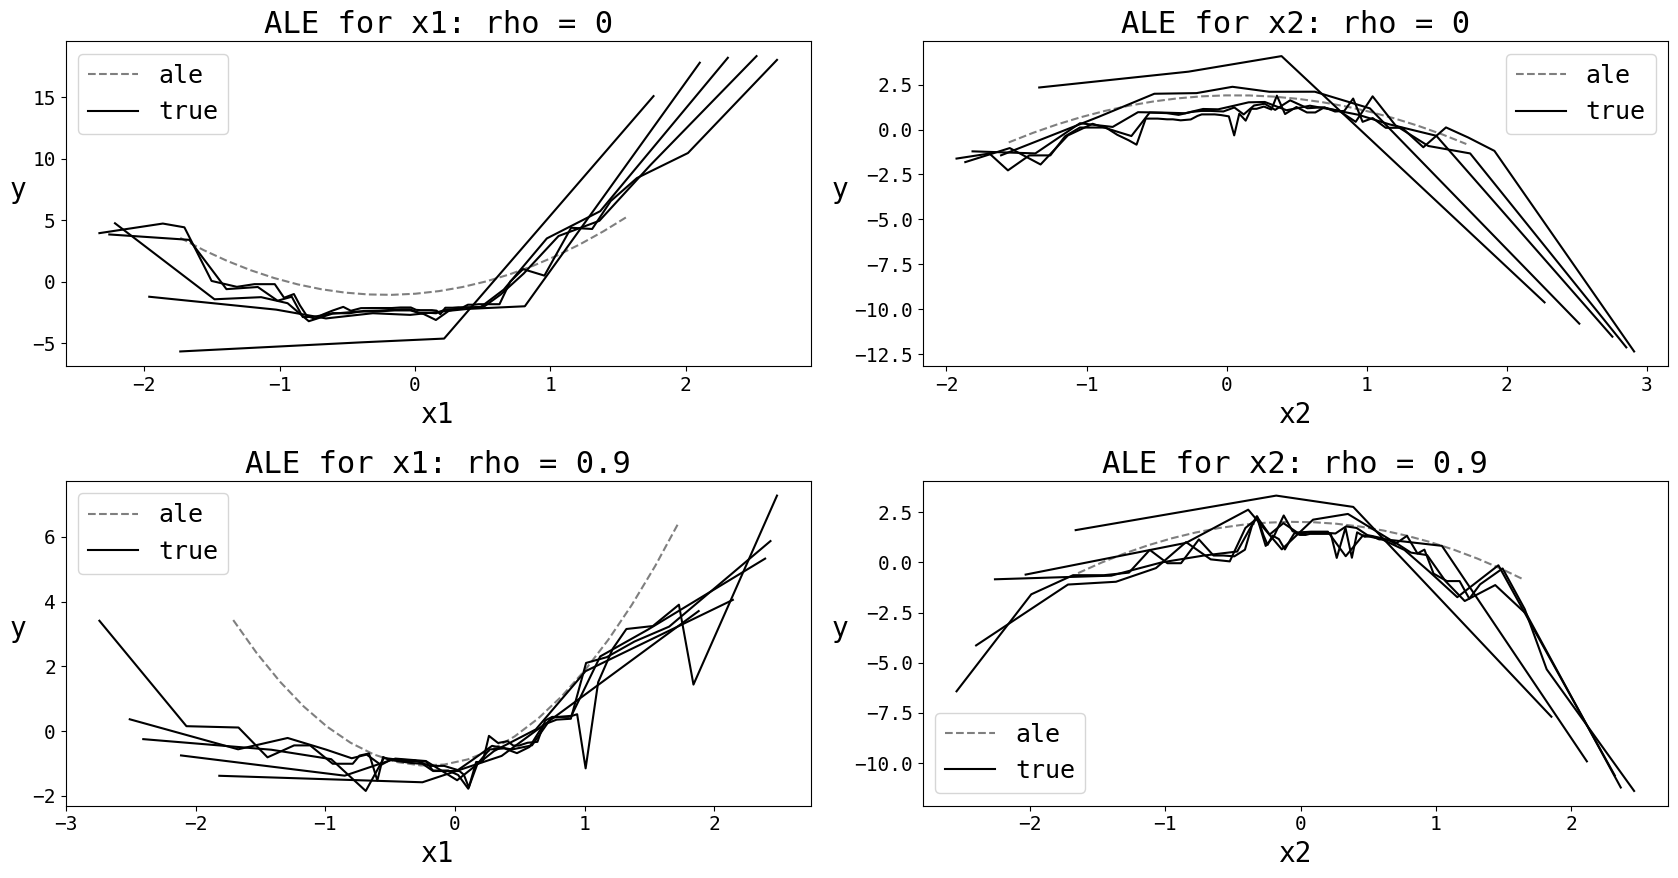

In [167]:
# Test several grid sizes
grid_test = [5,10,20,30,50]
rho_arr = [0,0.9]
fig, ax = plt.subplots(2,2, figsize = (17,9))
for r,rho in enumerate(rho_arr):
    y_c, x_c = simulate_nl_model(alpha, rho=rho, var_epsilon=5, nobs=300, seed=67219)
    # train GBR
    gbr_nl_c = GradientBoostingRegressor(random_state=state).fit(x_c, y_c.y)
    # get PDPs
    for c, col in enumerate(x_c.columns):
        ax_rc = ax[r,c]
        true_pdp = simulate_true_pdps(alpha, x_c, var_name=col)
        true_pdp['true_pdp2'].plot(ax=ax_rc, color='k', ls='--', alpha=0.5)
        for gz in grid_test:
            p2 = compute_ale(xdf=x_c, var_name=col, model=gbr_nl_c, grid_size=gz)
            p2['centered_ale'].plot(ax=ax_rc, color = 'k')
        ax_rc.legend(['ale', 'true'], fontsize=18)
        ax_rc.set_title(f'ALE for {col}: rho = {rho}')
        ax_rc.set_ylabel('y ', rotation=0)
        ax_rc.set_xlabel(col, rotation=0)    


In [168]:
def compute_ale_boot(xdf, var_name, boot_smpl, grd_size, model):
    "Bootstrap ALE estimates"
    nobs, ncol = xdf.shape
    for b in range(boot_smpl):
        ix_b = np.random.choice(xdf.index, size=nobs, replace=True)
        x_b = xdf.loc[ix_b]
        df_ale = compute_ale(xdf=x_b, var_name=var_name, model=model, grid_size=grd_size)
        if b==0:
            df_boot = df_ale[['centered_ale']].copy()
            df_boot.rename(columns={'centered_ale':0}, inplace=True)
        else:
            df_boot[b] = df_ale['centered_ale'].values
    # transpose to have grid as columns
    df_boot = df_boot.T
    df_boot = df_boot.astype('float')
    return df_boot

test_boot_ale = compute_ale_boot(xdf=x_c, var_name = 'x1', boot_smpl=5, grd_size = 5, model = gbr_nl_c)
test_boot_ale.quantile(0.95)

mid_point
-1.819550   -0.633539
-0.275590   -0.670063
 0.314545    0.109035
 1.522227    4.012371
Name: 0.95, dtype: float64

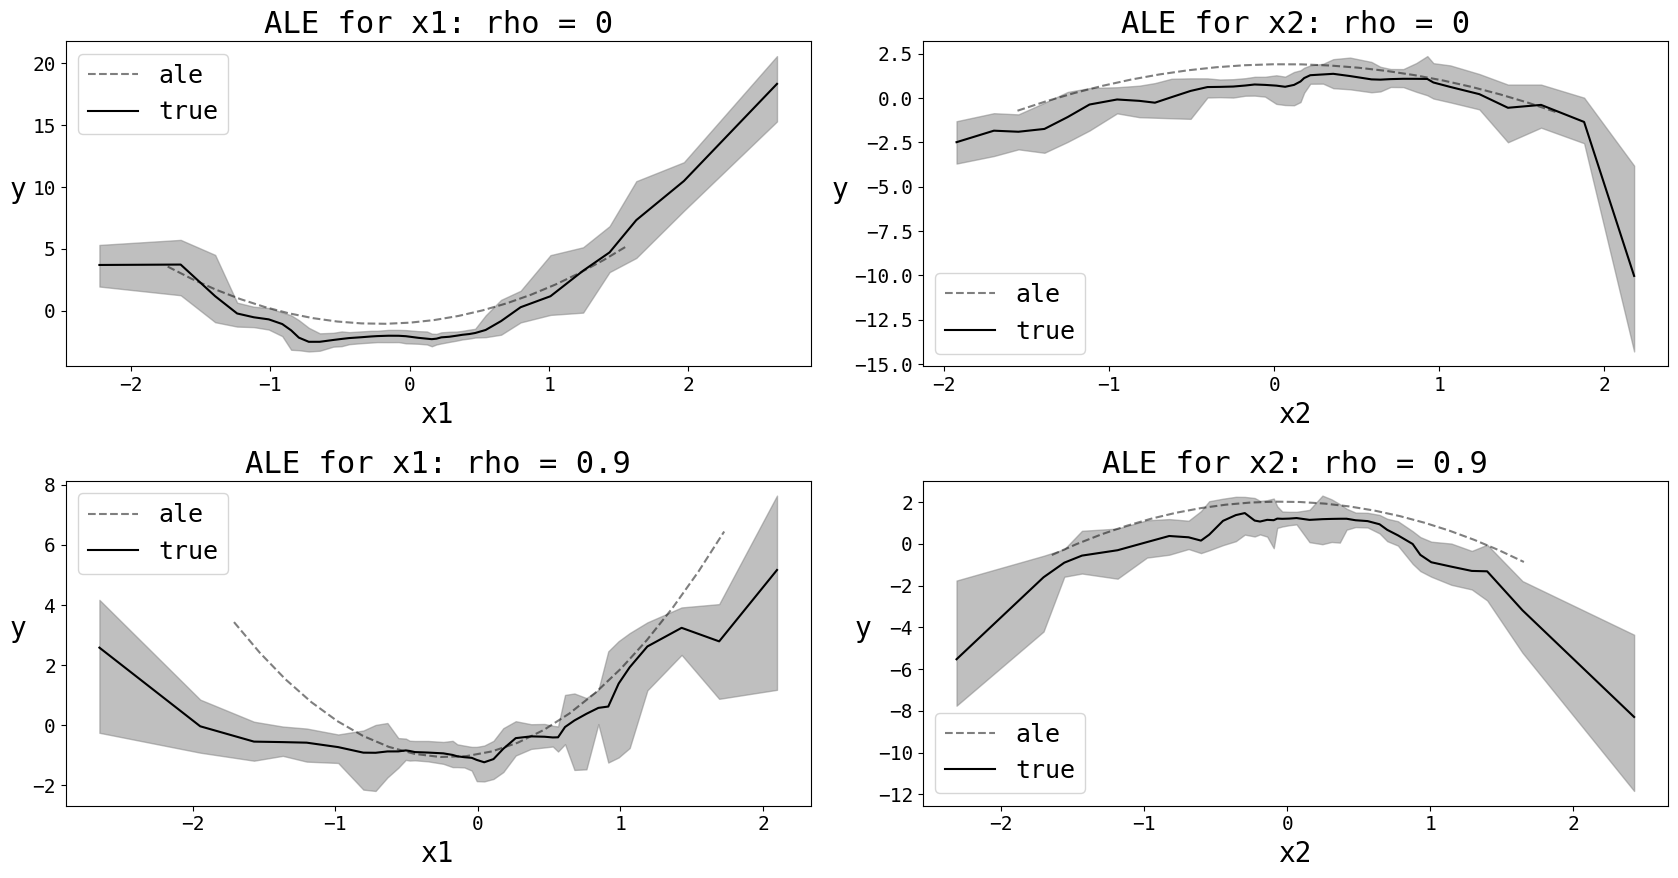

In [169]:
# Bootstrap the estimates
grid_size = 40
rho_arr = [0,0.9]
fig, ax = plt.subplots(2,2, figsize = (17,9))
for r,rho in enumerate(rho_arr):
    y_c, x_c = simulate_nl_model(alpha, rho=rho, var_epsilon=5, nobs=300, seed=67219)
    # train GBR
    gbr_nl_c = GradientBoostingRegressor(random_state=state).fit(x_c, y_c.y)
    # get PDPs
    for c, col in enumerate(x_c.columns):
        ax_rc = ax[r,c]
        true_pdp = simulate_true_pdps(alpha, x_c, var_name=col)
        true_pdp['true_pdp2'].plot(ax=ax_rc, color='k', ls='--', alpha=0.5)
        # bootstrapping ALE
        boot_c = compute_ale_boot(xdf=x_c, var_name = col, boot_smpl=100, grd_size = grid_size, model = gbr_nl_c)
        mean_c = boot_c.mean()
        mean_c.plot(ax=ax_rc, color = 'k')
        top_c = boot_c.quantile(0.95)
        bot_c = boot_c.quantile(0.05)
        ax_rc.fill_between(mean_c.index, top_c, bot_c, color='0.5', alpha = 0.5)
        ax_rc.legend(['ale', 'true'], fontsize=18)
        ax_rc.set_title(f'ALE for {col}: rho = {rho}')
        ax_rc.set_ylabel('y ', rotation=0)
        ax_rc.set_xlabel(col, rotation=0)    
